In [1]:
import metpy
import datetime
import rioxarray
import os
import glob
import warnings

import geopandas as gpd
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature

from plotting import histogram_density_plot

# 2017 Data had a different CRS and I did not use the proper one when trimming and matching PM and AOD

In [40]:
things = {}
for year in range(2017, 2022):
    with xr.open_dataset(f'/Volumes/Shores/GOES/AODC/averages/{year}/daily/144.nc') as a:
        a.load()
    things[year] = a.goes_imager_projection.perspective_point_height, a.goes_imager_projection.longitude_of_projection_origin

In [41]:
things

{2017: (35786023.0, -89.5),
 2018: (35786023.0, -75.0),
 2019: (35786023.0, -75.0),
 2020: (35786023.0, -75.0),
 2021: (35786023.0, -75.0)}

In [54]:
with xr.open_dataset(f'/Volumes/Shores/GOES/AODC/averages/2017/daily/334.nc') as a:
    a.load()
a.goes_imager_projection.perspective_point_height, a.goes_imager_projection.longitude_of_projection_origin, a.t

(35786023.0,
 -89.5,
 <xarray.DataArray 't' (t: 1)>
 array(['2017-11-30T00:00:00.000000000'], dtype='datetime64[ns]')
 Coordinates:
   * t                                (t) datetime64[ns] 2017-11-30
     y_image                          float32 0.08456
     x_image                          float32 -0.00504
     sunglint_angle                   float32 40.0
     retrieval_local_zenith_angle     float32 90.0
     quantitative_local_zenith_angle  float32 60.0
     retrieval_solar_zenith_angle     float32 90.0
     quantitative_solar_zenith_angle  float32 80.0
     aod_product_wavelength           float32 0.55)

In [55]:
with xr.open_dataset(f'/Volumes/Shores/GOES/AODC/averages/2017/daily/348.nc') as a:
    a.load()
a.goes_imager_projection.perspective_point_height, a.goes_imager_projection.longitude_of_projection_origin, a.t

(35786023.0,
 -75.0,
 <xarray.DataArray 't' (t: 6558)>
 array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
        '2000-01-03T00:00:00.000000000', ..., '2017-12-12T00:00:00.000000000',
        '2017-12-13T00:00:00.000000000', '2017-12-14T00:00:00.000000000'],
       dtype='datetime64[ns]')
 Coordinates:
   * t                                (t) datetime64[ns] 2000-01-01 ... 2017-1...
     y_image                          float32 0.08624
     x_image                          float32 -0.03136
     sunglint_angle                   float32 40.0
     retrieval_local_zenith_angle     float32 90.0
     quantitative_local_zenith_angle  float32 60.0
     retrieval_solar_zenith_angle     float32 90.0
     quantitative_solar_zenith_angle  float32 80.0
     aod_product_wavelength           float32 nan)

# Something weird with data quality flag in 2017/2018 data and not excluding stuff outside of 60 degrees

In [2]:
regions = gpd.read_file('data/ne_50m_admin_1_states_provinces.zip')
states = regions[regions.admin == 'United States of America']
contiguous_us = states[(states.name != 'Alaska') & (states.name != 'Hawaii')]

In [3]:
equal_area = ccrs.AlbersEqualArea(central_latitude=39.8283, central_longitude=-98.5795)
plate = ccrs.PlateCarree()

In [5]:
def plot_locations(locations, ax):
    ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.859375)
        return {'facecolor': facecolor, 'edgecolor': '#00000033'}

    ax.add_geometries(
        contiguous_us.geometry,
        ccrs.PlateCarree(),
        styler=colorize_state)

    ax.set_extent([-120, -72, 25, 48.8], plate)

    ax.scatter(locations.longitude, locations.latitude,
           s=4, 
           alpha=0.4, 
           c='r',
           edgecolor='black',
           transform=ccrs.PlateCarree(), 
           zorder=10);

    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, alpha=0.2)
    gl.top_labels=False
    gl.right_labels=False
    xstyle = {'size': 8, 'rotation': 0, 'ha': 'center'}
    ystyle = {'size': 8, 'rotation': 0}
    gl.xlabel_style = xstyle
    gl.ylabel_style = ystyle
    ax.spines[:].set_visible(False)

In [6]:
df = pd.read_csv('data/matched/all_years_final_months.csv', parse_dates=['time'])
df.set_index('time', inplace=True)
locations = df.loc['2021'][['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

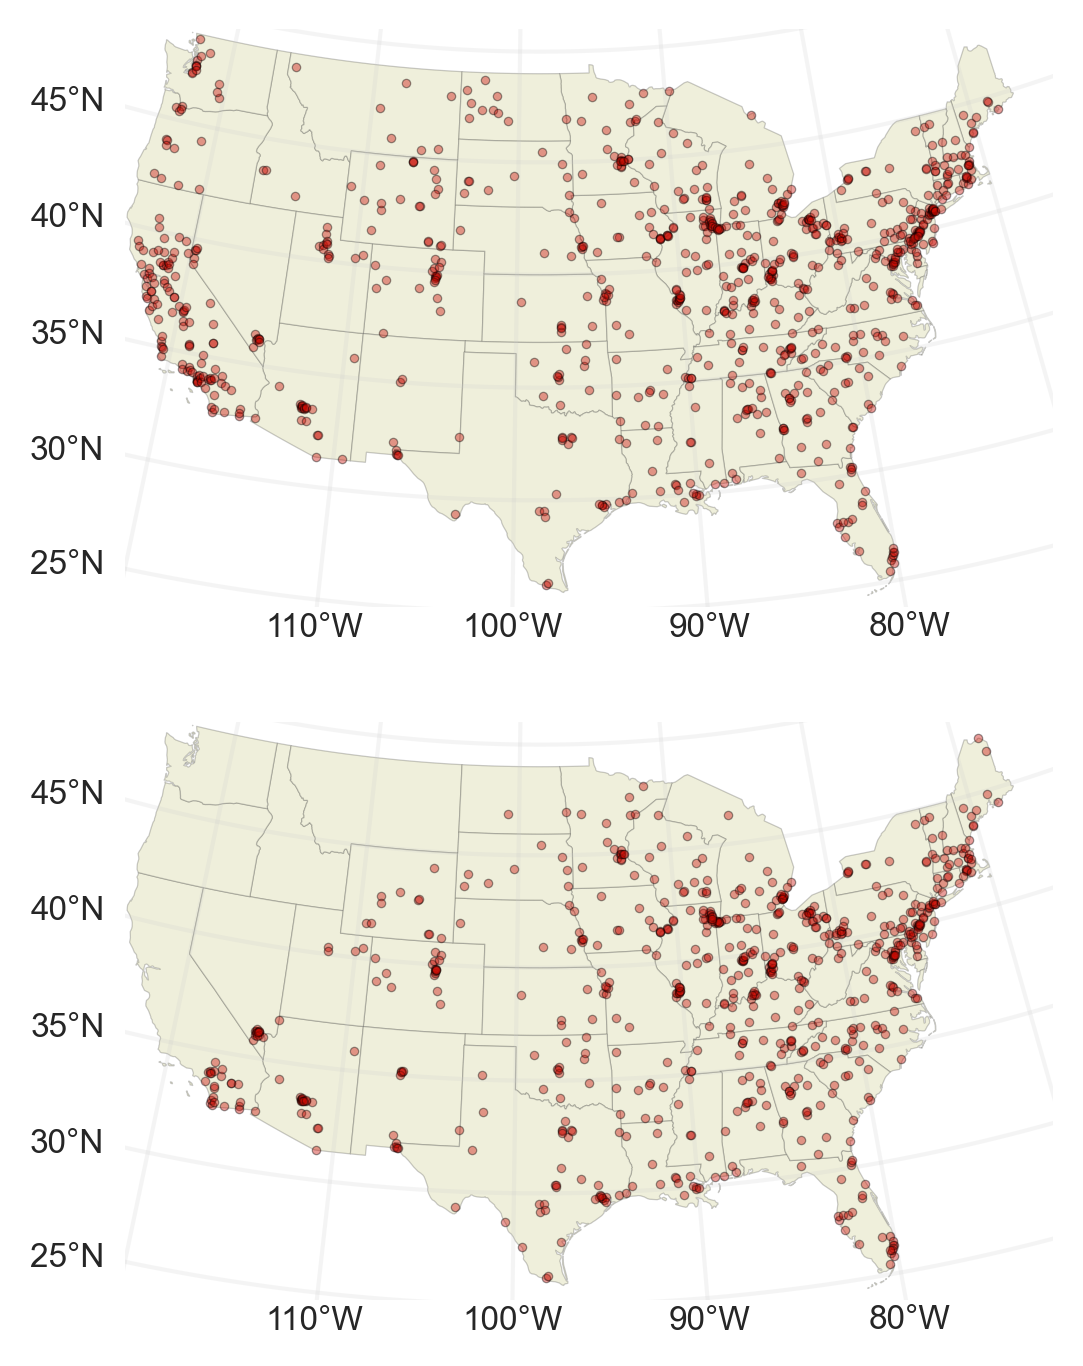

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, dpi=300, subplot_kw=dict(projection=equal_area))

_1 = df.loc['2017'][['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
_2 = df.loc['2021'][['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

plot_locations(_1, ax=ax1)
plot_locations(_2, ax=ax2)

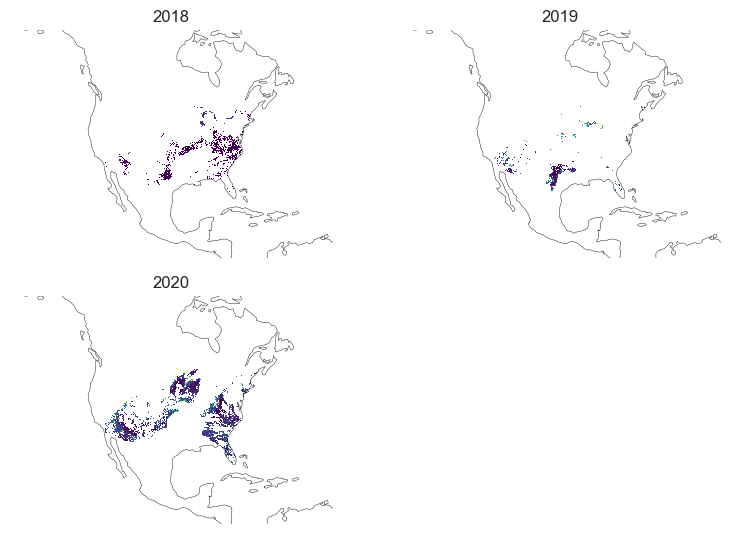

In [9]:
fig, axes = plt.subplots(2,2, subplot_kw=dict(projection=equal_area))

for year, ax in zip(range(2018, 2022), axes.ravel()):
    with xr.open_dataset(f'/Volumes/Shores/GOES/AODC/averages/{year}/095/18.nc') as ds:
        ds.load()
        
    a = ds.metpy.parse_cf('AOD')
    sath = ds.goes_imager_projection.perspective_point_height
    ds = ds.assign(x=ds.x*sath, y=ds.y*sath)
    proj = a.metpy.cartopy_crs

    ds.AOD.plot(ax=ax, add_colorbar=False, transform=proj, vmin=0, vmax=1)
    ax.set_title(pd.to_datetime(ds.t.item()).year)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    ax.coastlines()
    ax.spines[:].set_visible(False)
    

axes[-1,-1].set_visible(False)
fig.tight_layout()

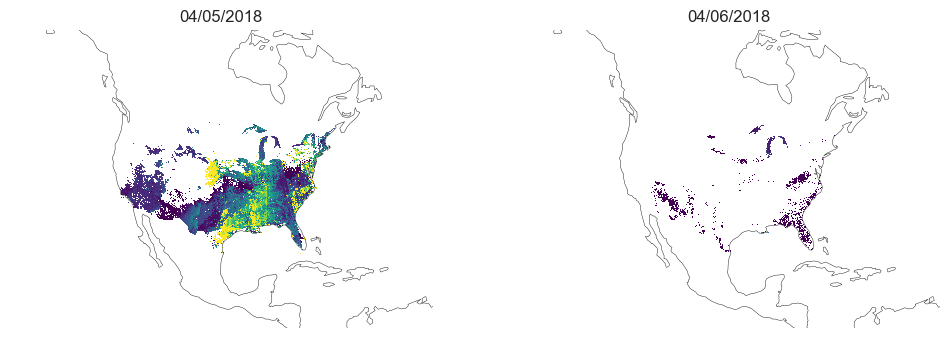

In [10]:
fig, axes = plt.subplots(1, 2, subplot_kw=dict(projection=equal_area), figsize=(12,7))

with xr.open_dataset(f'/Volumes/Shores/GOES/AODC/averages/2018/daily/095.nc') as ds:
    ds.load()

# for some reason, the data quality flag staring on day 96 appears to be correct
 
with xr.open_dataset(f'/Volumes/Shores/GOES/AODC/averages/2018/daily/096.nc') as ds2:
    ds2.load()

for ax, d in zip(axes, [ds, ds2]):
    sath = d.goes_imager_projection.perspective_point_height
    ds = d.assign(x=d.x*sath, y=d.y*sath)
    a = d.metpy.parse_cf('AOD')
    proj = a.metpy.cartopy_crs

    ds.AOD.plot(ax=ax, add_colorbar=False, transform=proj, vmin=0, vmax=1)
    ax.set_title(pd.to_datetime(d.t.item()).strftime('%m/%d/%Y'))
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.coastlines()
    ax.spines[:].set_visible(False)